In [1]:
from PIL import Image, ImageDraw, ImageColor
import numpy as np
import math
import itertools as it
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
#color maps
def color_map_black_and_white(n):
    """A black a white color spectrum"""
    if n >= 2:
        color_step_100 = 100/(n - 1)
    else:
        color_step_100 = 0
    black_and_white = [None] * n
    for i in range(n):
        progress = int(i*color_step_100)
        black_and_white[i] = f"hsl(0,0%,{progress}%)"
    return black_and_white
    
def color_map_rainbow(n):
    """produces a rainbow ordering"""
    l = [None] * n
    hue_step = 360/n
    for i in range(n):
        hue_value = hue_step * i
        l[i] = f"hsl({hue_value},100%,50%)"
    return l

def color_map_nmp(n,m,p):
    """produces an color ordering by n varies the hue, m varies the lightness, p varies the saturation
    lexicographically, you probably want n * m * p = group_order
    """
    l = [None] * (n * m * p)
    hue_offset = 15
    hue_step = 360/n
    lightness_initial = 40
    lightness_final = 70
    if m >= 2:
        lightness_step = (lightness_final - lightness_initial)/(m - 1)
    else:
        lightness_initial = 50
        lightness_step = 0
    saturation_initial = 40
    saturation_final = 100
    if p >= 2:
        saturation_step = (saturation_final - saturation_initial)/(p - 1)
    else:
        saturation_initial = 100
        saturation_step = 0
    
    for i in range(n):
        hue_value = int(hue_offset + hue_step * i)
        for j in range(m):
            lightness_value = int(lightness_initial + lightness_step * j)
            for k in range(p):
                saturation_value = int(saturation_initial + saturation_step * k)
                #this code can be varied to chance which one is inside (in the ordering)
                #hue on the outside seems best
                index = i * m * p + j * p + k
                l[index] = f"hsl({hue_value},{saturation_value}%,{lightness_value}%)"
    return l

def color_map_n1n2mp(n1,n2,m,p):
    """produces an color ordering by n1 and n2 varies the hue (lexicographically with eachother),
    m varies the lightness, p varies the saturation
    lexicographically, you probably want n1 * n2 * m * p = group_order
    """
    l = [None] * (n1 * n2 * m * p)
    hue_offset = 60
    hue_step1 = 360/n1
    squeeze_factor = 1.2
    hue_step2 = hue_step1/(n2 * squeeze_factor)
    lightness_initial = 40
    lightness_final = 70
    lightness_step = (lightness_final - lightness_initial)/(m - 1)
    saturation_initial = 60
    saturation_final = 100
    saturation_step = (saturation_final - saturation_initial)/(p - 1)
    for i1 in range(n1):
        for i2 in range(n2):
            hue_value = int(hue_offset + hue_step1 * i1 + hue_step2 * i2) % 360
            for j in range(m):
                lightness_value = int(lightness_initial + lightness_step * j)
                for k in range(p):
                    saturation_value = int(saturation_initial + saturation_step * k)
                    #this code can be varied to chance which one is inside (in the ordering)
                    #hue on the outside seems best
                    index = (i1 * n2 + i2) * m * p + j + k * m
                    l[index] = f"hsl({hue_value},{saturation_value}%,{lightness_value}%)"
    return l


In [3]:
class group_elt:
    def __init__(self):
        #in general this won't be used but for this for the geometric norm of elements (w/r/t generators)
        self.norm = None
    
    @classmethod
    def e(cls):
        pass
    
    def __eq__(self,other):
        pass
    
    def __ne__(self,other):
        return not(self == other)
        
    def __mul__(self, other):
        pass
    
    def invert(self):
        pass
    
    def __xor__(self,n):
        """computes self * ... (n) ... * self. If n is negative it inverts it"""
        if n > 0:
            return self * (self ^ (n-1))
        elif n == 0:
            return self.e()
        elif n < 0:
            return self.invert() ^ (-n)
    
    def order(self):
        self_to_the_n = self
        o = 1
        while self_to_the_n != self.e():
            self_to_the_n = self_to_the_n * self
            o += 1
        return o

In [4]:
class permutation(group_elt):
    """Bijections from {1,2,...,n} -> {1,2, ... ,n}"""
    def __init__(self,t):
        """t is a tuple with n elements 
        which is the one line notation for the permutation
        """
        self.one_line = t
        super(permutation, self).__init__()
        
    @classmethod
    def e_n(cls,n):
        """Gives the identity on n elements"""
        l = range(1,n+1)
        return permutation(tuple(l))
    
    @classmethod
    def from_string(cls,s):
        string = str(s)
        n = len(string)
        l = [int(string[i]) for i in range(n)]
        return cls(tuple(l))
        
    def length(self):
        return len(self.one_line)
    
    def __eq__(self,other):
        if self.length() == other.length():
            return self.one_line == other.one_line
        else:
            n = max(self.length(),other.length())
            sigma = self.embed(n)
            tau = other.embed(n)
            return sigma == tau    
    
    def __hash__(self):
        #Note this isn't safe for groups which use very large elements
        return hash(self.embed(100).one_line)
    
    def __mul__(self, other):
        """multiplies with self \circ other self.length() == other.length() better be true"""
        if self.length() == other.length():
            tau = other.one_line
            product_as_list = [tau[i - 1] for i in self.one_line]
            return permutation(tuple(product_as_list))
        else:
            #print("Warning: Multiplying permutations of uneven length")
            n = max(self.length(),other.length())
            sigma = self.embed(n)
            tau = other.embed(n)
            return sigma * tau
    
    def invert(self):
        l = list(self.one_line)
        m = [l.index(i) + 1 
             for i in range(1,self.length() + 1)]
        return permutation(tuple(m))
    
    @classmethod
    def e(cls):
        """Independent Identity: Uses that I can multiply with uneven length"""
        return cls.e_n(1)
    
    def e(self):
        """Depenedent Identity: Analyzes how big self is an choose the right length identity"""
        n = self.length()
        return self.e_n(n)
    
    def __str__(self):
        if self.length() <= 9:
            return "".join(map(str,self.one_line))
        else:
            return "<" + ",".join(map(str,self.one_line)) + ">"
    
    def __repr__(self):
        return self.__str__()
    
    def embed(self,m):
        n = self.length()
        if not n <= m:
            raise Exception("Permutations only embed if you increase their size")
        return permutation(self.one_line + tuple(range(n + 1, m + 1)))
    
    def __add__(self,other):
        """Returns the disjoint (block) sum of two permutations"""
        t = self.one_line
        n = self.length()
        u = other.one_line
        shifted_u = tuple(map(lambda x: x + n, u))
        return permutation(t + shifted_u)
    
    @classmethod
    def cycle(cls,n):
        """Gives a cycle of length n"""
        l = list(range(2,n+1))
        l.append(1)
        return permutation(tuple(l))
    
    def act(self, i):
        """Has self act on the set {1,2,..., n} in the canonical way"""
        return self.one_line[i - 1]

#For convenience
st = permutation.from_string

In [5]:
debug = False
class group:
    """An ordered group"""
    def __init__(self,l):
        """l should be a list of group elements, the multiplication etc is internal"""
        self.elements = l
    
    def quick_verify(self):
        """Verifies that self is built on a set and is closed under multiplication
        essentially this is verifying self is a magma"""
        elts = self.elements
        e = elts[0].e()
        if len(set(elts)) != len(elts):
            raise Exception("Group has duplicates")
        
        for g in elts:
            for h in elts:
                if not (g * h in elts):
                    raise Exception("Group not closed under multiplication")
        return "Passed"
    
    def verify(self):
        """Verifies that self is a group (has all the laws), self should have group_elts which are hashable"""
        elts = self.elements
        e = elts[0].e()
        if len(set(elts)) != len(elts):
            raise Exception("Group has duplicates")
        
        for g in elts:
            for h in elts:
                if not (g * h in elts):
                    raise Exception("Group not closed under multiplication")
        
        for g in elts:
            if not g * e == g:
                raise Exception("The right identity law failed")
            if not e * g == g:
                raise Exception("The left identity law failed")
            if not g * g.invert() == e:
                raise Exception("The right inverse law failed")
            if not g.invert() * g == e:
                raise Exception("The right inverse law failed")
                
        for g in elts:
            for h in elts:
                for k in elts:
                    if not g * (h * k) == (g * h) * k:
                        raise Exception("The associative law failed")
        return "Passed"
    
    def order(self):
        return len(self.elements)
    
    def exponent(self):
        return max([g.order() for g in self.elements])
        
    def __str__(self):
        return str(self.elements)
    
    def left_coset(self, g):
        """Returns a list of elements of the left coset g * self"""
        elts = self.elements
        return [g * h for h in elts]
    
    def center(self):
        """The center of a finite group is the subgroup elements 
        which commute with every element of the group
        """
        elts = self.elements
        return self.__class__([g for g in elts 
                               if all(g * h == h * g for h in elts)]) 
    
    def commuting_graph(self):
        """The commuting graph of a finite group G is a graph
        with vertices G - Z(G) and edges (g,h) if g and h commute
        """
        elts = self.elements
        centerelts = self.center().elements
        noncenterelts = [g for g in elts if g not in centerelts]
        C = nx.Graph()
        C.add_nodes_from(noncenterelts)
        C.add_edges_from([(g,h) for g in noncenterelts for h in noncenterelts if g * h == h * g])
        C.remove_edges_from(nx.selfloop_edges(C))
        return C
    
    @classmethod
    def cyclic_subgroup(cls,g):
        """Returns the subgroup generated by self 
        (self should have finite order)
        """
        return cls([g^i for i in range(g.order())])
    
    def elementwise_times(cls,J,L):
        """J and L should be lists of elements,
        returns the elementwise product
        in the lexicographic order with L being the little ordering
        """
        def gL(g,L):
            return [g * h for h in L]
        return list(np.hstack([gL(h,L) for h in J]))
    
    @classmethod
    def internal_product(cls,H,K):
        """Computes the internal product of H and K in some abient supergroup.
        For this to be a group in should be the case that one of H or K is normal in the supergroup"""
        H_elts = H.elements
        K_elts = K.elements
        HK_elts_naive = cls.elementwise_times(cls,K_elts,H_elts) 
        #I don't know why the order is like this but this is the answer I expect
        HK_elts = []
        for g in HK_elts_naive:
            if g not in HK_elts:
                HK_elts.append(g)
        return(cls(HK_elts))
    
    @classmethod
    def join(cls,H_group,K_group):
        """Suppose H and K are subgroups of some group then this returns H join K the smallest subgroup that contains both H and K
        The order on H and K is determined by treating H join K as some K cosets and trying to be smart about the order
        I assume H and K are disjoint up to the identity
        """
        H = H_group.elements
        K = K_group.elements
        e = H[0].e()
        if set(H) & set(K) != {e}:
            raise Exception(f"Your two groups: {str(H)}, {str(K)} intersect nontrivially")
        if debug: print("K =", K)
        
        S = [e]
        for a in H:
            for b in K: 
                c = b * a * b.invert()
                its_new = True
                for r in S:
                    u = c * r.invert()
                    if u in K:
                        its_new = False
                        break
                if its_new:
                    S.append(c)
        if debug: print("S =", S)
        
        T = S
        T_old = []
        G = cls.elementwise_times(cls,S,K)
        while T != T_old:
            T_old = T
            for s in S:
                for t in T_old:
                    st = s * t
                    if st not in G:
                        T.append(st)
                        G = G + cls.elementwise_times(cls,[st],K)
                    #its_new = True
                    #for r in T:
                    #    u = st * r.invert()
                    #    if u in K:
                    #        its_new = False
                    #        break
                    #if its_new:   
            if debug: print("#T =", len(T), "T =", T)
        return cls(G)
    
    @classmethod
    def generate(cls, *generators, key = 'Cosets'):
        """Returns the subgroup generated by generators"""
        if key == 'Geometric':
            #the order comes from growing balls at 0 in the Cayley graph with generators as args
            #we start at r = 0 and consider the open balls (in the geometry on our target group)
            r = 0
            B_r = []
            e = generators[0].e()
            e.norm = 0
            S_r = [e] #The sphere of radius r
            S_pm_duplicates = list(generators) + [g.invert() for g in generators]
            S_pm = []
            for g in S_pm_duplicates:
                if g not in S_pm:
                    S_pm.append(g)

            while S_r:
                if debug:
                    print("r =", r, "#B_r =", len(B_r), "#S_r =", len(S_r))
                r += 1
                B_r = B_r + S_r
                #the tubular neighborhood around S_r
                N_1_S_r = [s * g for g in S_r for s in S_pm]
                S_r = []
                for g in N_1_S_r:
                    if g not in B_r and g not in S_r:
                        g.norm = r
                        S_r.append(g)
            if debug:
                    print("r =", r, "#B_r =", len(B_r), "#S_r =", len(S_r))
            return cls(B_r)
        elif key == 'Normal Closure':
            #builds cosets in a recursive way
            #generate(g) = [e , g , g^2 , ...]
            #if generate(h_2, ... ,h_n) = H
            #then generate(h_1, ... , h_n) = join(H,cyclic_subgroup(h_n))
            if len(generators) == 1:
                return cls.cyclic_subgroup(generators[0])
            else:
                return cls.join(
                    cls.cyclic_subgroup(generators[0]),cls.generate(*generators[1:],key = 'Normal Closure'))
        elif key == 'Cosets':
            if len(generators) == 1:
                return cls.cyclic_subgroup(generators[0])
            else:
                G = cls.generate(*generators, key = 'Normal Closure')
                H = cls.generate(*generators[1:], key = 'Cosets')
                #print(f"G is {G}")
                #print(f"H is {H}")
                return G.reorder_by_subgroup(H)
        else:
            raise Exception("Unsupported Key:", key)
    
    def maxnorm(self):
        """Returns the maximum norm of elements in G"""
        norms = [g.norm for g in self.elements]
        if None in norms:
            raise Exception("You don't have norms computed for all the elements in", str(self))
        return max(norms)
    
    def reorder_by_subgroup(self,H):
        """Takes a subgroup H of self and reorder self by H is the first elts
        this method requires * to be defined correctly
        only returns a list of the elements"""
        G = self
        H_elts = H.elements
        new_order = H_elts[:]
        remaining_elts = G.elements[:]
        try:
            remaining_elts[0] * new_order[0]
        except:
            raise Exception("H is not a subgroup of self")
        for h in H_elts:
            remaining_elts.remove(h)
            
        while remaining_elts:
            g = remaining_elts[0]
            #I think this loop structure doesn't work because say take a central extension of Q8
            #for i in range(1,G.order() // H.order()):
            #instead I look for coset representatives as g^i until that's in H
            i = 1
            while not(g^i in set(H.elements)):
                new_order = new_order + H.left_coset(g ^ i)
                i = i + 1
            for k in new_order:
                try:
                    remaining_elts.remove(k)
                except ValueError:
                    pass
        return self.__class__(new_order)
    
    def abstract_cayley_table(self,approximate_size = 500):
        """Returns the times table for a group
        Useful to speed up computations"""
        #set up
        elts = self.elements
        order = self.order()
        
        #choose progress bar and approximate size based on size
        if order >= 200:
            print("This is going to take a while stand by:")
            progress_bar = True
            if order <= 1000:
                progress_bar_levels = 5
                if approximate_size == 500:
                    approximate_size = 1000
            elif order <= 2000:
                progress_bar_levels = 2
                if approximate_size == 500:
                    approximate_size = 2000
            else:
                progress_bar_levels = 1
            progress_bar_step = int(order/(100 / progress_bar_levels))
        else:
            progress_bar = False
            
        #length = int(approximate_size/order) * order
        
        abstract_table = [[None] * order for i in range(order)]
        for i in range(order):
            for j in range(order):
                #I give the convention the it's the y-axis elements times the x-axis elements
                abstract_table[i][j] = elts.index(elts[j] * elts[i])
            if progress_bar:
                if i % progress_bar_step == 0:
                    print(int(i/order * 100),"% done")
        
        return abstract_table
        
    def cayley_table(self,approximate_size = 500,
                     color_map=None,color_key='White and Black',drawing_key="Inline",
                     precomputed_table=None):
        """Draws the Cayley Table of self, color map is a list of color strings for pillow to use"""
        #set up
        elts = self.elements
        order = self.order()
        
        #decide if a progress bar is needed
        if order >= 200:
            progress_bar = True
            if order <= 1000:
                if approximate_size == 500:
                    approximate_size = 1000
            elif order <= 2000:
                if approximate_size == 500:
                    approximate_size = 2000
        else:
            progress_bar = False
        length = int(approximate_size/order) * order
        
        #choose color map
        if color_key == None or (color_key == 'White and Black' and color_map != None):
            pass
        elif color_key == 'White and Black' and color_map == None:
            color_map = color_map_black_and_white(order)
            color_map.reverse()
        elif color_key == 'Rainbow':
            color_map = color_map_rainbow(order)
        elif color_key == 'Red e':
            color_map = color_map_black_and_white(order)
            color_map.reverse()
            for g in elts:
                if g == elts[0].e():
                    color_map[elts.index(g)] = 'Red'
        else:
            raise Exception(f"Unsupported key: {color_key}")
        
        #set up draw engine
        step_count = order
        image = Image.new(mode = 'RGB', size=(length, length), color="red")
        draw = ImageDraw.Draw(image)
        step_size = int(image.width / step_count)
        if step_size == 0:
            raise Exception("Your image size is too small to draw a group this big")
        
        scaled_axis = range(0, image.width, step_size)

        #Draw the Table (abstractly)
        if precomputed_table == None:
            abstract_table = self.abstract_cayley_table()
        else:
            abstract_table = precomputed_table
        
        #Draw the table (actually)
        if progress_bar:
            print("Drawing abstract table to an image")
        for i in range(order):
            for j in range(order):
                x = scaled_axis[i]
                y = scaled_axis[j]
                rectangle = ((x,y),(x+step_size,y+step_size))
                #I give the convention the it's the y-axis elements times the x-axis elements
                c = color_map[abstract_table[i][j]]
                draw.rectangle(rectangle, fill=c)

        if(drawing_key == "Inline"):
            plt.imshow(image)
            plt.axis('off')
        elif(drawing_key == "PNG"):
            image.show()
        else:
            raise Exception(f"Unsupported Drawing Key {drawing_key}")
        del draw

In [6]:
class sgroup(group):
    """A group embedded in S_n for some n"""
    def __init__(self,l):
        """l should be a list of permutations which has group structure"""
        super(sgroup, self).__init__(l)
        
    def __mul__(self,other):
        """Computes the direct product of self and other"""
        out_list = [g + h for (g,h) in it.product(self.elements,other.elements)]
        return sgroup(out_list)
    
    def __xor__(self,n):
        """computes self * ... (n) ... * self."""
        if n > 0:
            return self * (self ^ (n-1))
        elif n == 0:
            return self.trivial()
    
    @classmethod
    def trivial(cls):
        return cls([permutation.e_n(1)])
    
    @classmethod
    def zmodn(cls,n):
        """The cyclic group of order n"""
        sigma = permutation.cycle(n)
        return cls.cyclic_subgroup(sigma)
    
    @classmethod
    def an(cls,n):
        sn_elts = cls.sn(n,'Lexicographic').elements
        an_elts = []
        standard_basis = np.identity(n)
        for sigma in sn_elts:
            matrix_rep = [standard_basis[sigma.act(i) - 1] for i in range(1,n+1)]
            if round(np.linalg.det(matrix_rep)) == 1:
                an_elts.append(sigma)
        return cls(an_elts)
    
    @classmethod
    def sn(cls,n,key = 'A_n'):
        """The symmetric group acting on sets of size n, so of order n!"""
        if key == 'Lexicographic':
            sn_elts_tuples = it.permutations(
            tuple(range(1,n+1)))
            sn_elts = [permutation(t) for t in sn_elts_tuples]
            return cls(sn_elts)
        if key == 'A_n':
            return cls.sn(n,'Lexicographic').reorder_by_subgroup(cls.an(n))
        if key == 'Geometric':
            return cls.generate(permutation.cycle(n),st(21),key = 'Geometric')
        
    @classmethod
    def dn(cls,n,key = 'Z/n subgroup'):
        """The dihedral group of order 2n"""
        if key == 'Z/n subgroup':
            r = permutation.cycle(2*n)^2
            s = permutation((2,1) + tuple(it.chain(*[(2*(n-i),2*(n-i)-1) for i in range(n-1)])))
            return cls.generate(s,r, key = 'Cosets')
        

In [ ]:
#sgroup.dn(4).cayley_table(color_key = "Rainbow")
S4 = sgroup.an(4)
Z2 = sgroup.zmodn(2)
G = (S4^3)
G.cayley_table()
#G.cayley_table(color_map = color_map_n1n2mp(4,2,2,2))
#G.cayley_table()

This is going to take a while stand by:
0 % done
1 % done
3 % done
5 % done
7 % done
9 % done
11 % done
13 % done
15 % done
17 % done
19 % done
21 % done
23 % done
25 % done
27 % done
29 % done
31 % done
33 % done
35 % done
37 % done
39 % done
41 % done
43 % done
45 % done
47 % done
49 % done
51 % done
53 % done
55 % done
57 % done
59 % done
60 % done


In [10]:
S4 = sgroup.sn(4)
h1 = st(3412)
h1t = st(2143)
h2 = st(2314)
h3 = st(2134)
composition_order = sgroup.generate(h3,h2,h1t,h1, key = "Normal Closure")
cmap = color_map_n1n2mp(3,2,2,2)
cmap[0] = "White"
color_map = color_map_black_and_white(24)
color_map.reverse()
color_map[0] = 'Red'

#Latin Square Property Demo
elts = composition_order.elements
order = 24
step_count = order
length = int(500/order) * order
image = Image.new(mode = 'RGB', size=(length, length), color="red")
draw = ImageDraw.Draw(image)
step_size = int(image.width / step_count)
if step_size == 0:
    raise Exception("Your image size is too small to draw a group this big")
        
scaled_axis = range(0, image.width, step_size)

abstract_table = composition_order.abstract_cayley_table()
        
        #Draw the table (actually)
for i in range(order):
    for j in range(order):
        x = scaled_axis[i]
        y = scaled_axis[j]
        rectangle = ((x,y),(x+step_size,y+step_size))
        #I give the convention the it's the y-axis elements times the x-axis elements
        if j == 0 or j == 11:
             c = color_map[abstract_table[i][j]]
        else:
            c = "Yellow"
        draw.rectangle(rectangle, fill=c)
image.show()
#composition_order.cayley_table(color_map = color_map, drawing_key = "PNG")

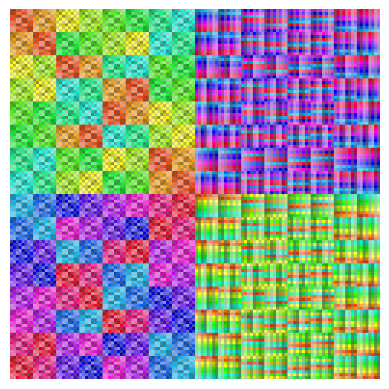

In [86]:
#2-sylow in S_8
debug = False
g2 = st(21345678)
g3 = st(34125678)
g2p = st(12346578)
g3p = st(12347856)
g1 = st(56781234)
G_naive_order = sgroup.generate(g1,g2,g3, key = "Cosets")
G = G_naive_order.reorder_by_subgroup(sgroup.generate(g2p,g3p,g2,g3))
#black_and_white = color_map_black_and_white(2)
#norm_colors = color_map_rainbow(G.maxnorm() + 1)
#for i in range(0,G.maxnorm() + 1):
#    if i % 2 == 1:
#        norm_colors[i] = black_and_white[0]
#colors = [norm_colors[g.norm] for g in G.elements]
G.cayley_table(color_map = color_map_nmp(16,4,2), drawing_key = "Inline")

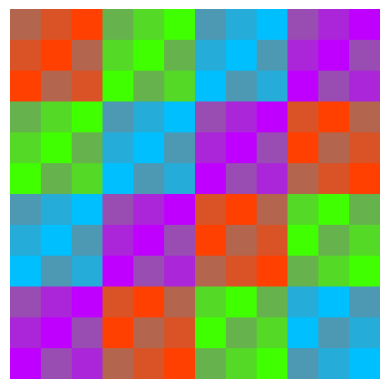

In [11]:
Z12 = sgroup.zmodn(12)
g = permutation((5,6,7,8,9,10,11,12,1,2,3,4))
Z12_new = Z12.reorder_by_subgroup(sgroup.generate(g))
Z12_new.cayley_table(color_map = color_map_nmp(4,1,3))

In [157]:
Z2 = sgroup.zmodn(2)
Z4 = sgroup.zmodn(4)
Z8 = sgroup.zmodn(8)
Z2_in_Z8 = sgroup.generate(st(56781234))
Z8_twisted = sgroup.internal_product(Z2_in_Z8,Z8)
D8 = sgroup.generate(st(4321),permutation.cycle(4),key = "Cosets")
Q8 = sgroup.generate(st(21436587),st(34215687))

#Z8.cayley_table(drawing_key = "PNG")
#(Z2 ^ 3).cayley_table(drawing_key = "PNG")
#(Z4*Z2).cayley_table(drawing_key = "PNG")
#D8.cayley_table(drawing_key = "PNG")
#Q8.cayley_table(drawing_key = "PNG")

#Harder version
(Z4 * Z2).cayley_table(drawing_key = "PNG", color_map = color_map_nmp(4,2,1))
Z8_twisted.cayley_table(drawing_key = "PNG", color_map = color_map_nmp(4,2,1))

In [19]:
G = sgroup.sn(6, key = "Geometric")
t = G.abstract_cayley_table()

This is going to take a while stand by:
0 % done
5 % done
10 % done
15 % done
20 % done
25 % done
30 % done
35 % done
40 % done
45 % done
50 % done
55 % done
60 % done
65 % done
70 % done
75 % done
80 % done
85 % done
90 % done
95 % done


In [39]:
x = 511
cut_off = ['Black'] * x + ['White'] * (720 - x)
G.cayley_table(precomputed_table = t, color_map = color_map_black_and_white(720), drawing_key = "PNG")

Drawing abstract table to an image


In [40]:
#G = sgroup.zmodn(300)
#g = G.elements[7]
Zn = sgroup.zmodn(18)
#H = sgroup.generate(g)
e = (Zn^2).elements
G = sgroup.generate(e[1],e[21])
o = G.order()
print(o)
x = 150
cut_off = ['Black'] * x + ['White'] * (o - x)
t = G.abstract_cayley_table()
G.cayley_table(precomputed_table = t, color_map = cut_off, drawing_key = "PNG")
G.cayley_table(precomputed_table = t, color_map = color_map_black_and_white(o), drawing_key = "PNG")

324
This is going to take a while stand by:
0 % done
4 % done
9 % done
14 % done
19 % done
24 % done
29 % done
34 % done
39 % done
44 % done
49 % done
54 % done
59 % done
64 % done
69 % done
74 % done
79 % done
83 % done
88 % done
93 % done
98 % done
Drawing abstract table to an image
Drawing abstract table to an image


Graph with 11 nodes and 7 edges
Number of connected components: 5
Graph with 0 nodes and 0 edges


TypeError: analyze_symmetry() missing 3 required positional arguments: 'graph', 'node_partitions', and 'edge_colors'

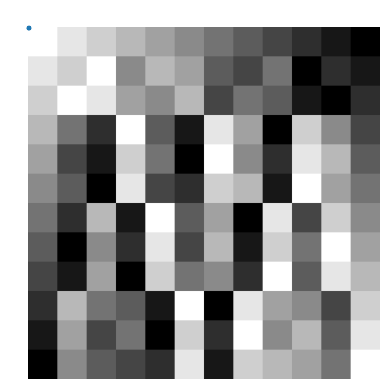

In [158]:
G = sgroup.an(4)
G.cayley_table(drawing_key = "Inline")
A = G.commuting_graph()
print(A)
print("Number of connected components:", nx.number_connected_components(A))
components = [A.subgraph(c).copy() for c in sorted(nx.connected_components(A), key = len, reverse = True)]
nx.draw(A, node_size = 2)
largest_cc = max(nx.connected_components(A), key=len)
weakcenter = A.subgraph(largest_cc).copy()
extremities = [u for (u,k) in weakcenter.degree() if k == 2]
lessweakcenter = A.subgraph([u for u in largest_cc if u not in extremities]).copy()
print(lessweakcenter)
nx.isomorphism.ISMAGS(lessweakcenter,lessweakcenter)
nx.isomorphism.ISMAGS.analyze_symmetry(lessweakcenter)
nx.draw(nx.check_planarity(lessweakcenter,True)[1],node_size = 3)
pos = nx.nx_agraph.graphviz_layout(lessweakcenter, prog="twopi", args="")
nx.draw(lessweakcenter, pos, node_size = 2)

41352


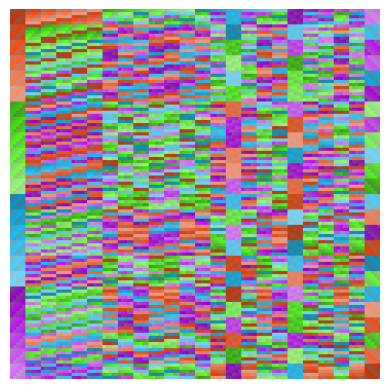

In [33]:
g1 = st(23451)
g2 = st(21)
G1 = sgroup.generate(g2,g1,key = 'Cosets')
elts = G1.elements
G1.cayley_table(drawing_key = "Inline", color_map = color_map_nmp(4,6,5))

x = elts[(15 - 1) * 5 + 0]
print(x)
G2 = sgroup.generate(g1,x,key = 'Cosets')
G2.cayley_table(drawing_key = "PNG", color_map = color_map_nmp(5,4,1))

[1234, 2314, 3124, 2143, 3241, 1342, 3412, 1423, 2431, 4321, 4132, 4213, 1243, 2341, 3142, 2134, 3214, 1324, 3421, 1432, 2413, 4312, 4123, 4231]


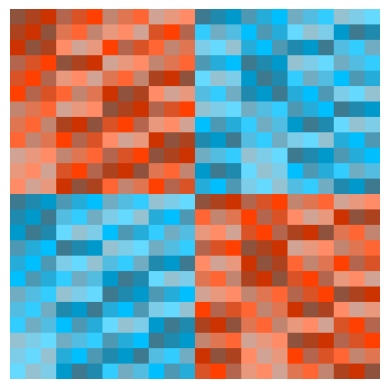

In [74]:
perm4 = st
#Making an ordering for the composition series 1 < Z/2 < V_4 < A_4 < S_4
z2 = [permutation.e_n(4),perm4(2143)]
h1 = perm4(3412)
h2 = perm4(2314)
h3 = perm4(2134)
composition_order = sgroup.generate(h1,h2,h3, key = "Cosets")

#composition_order.cayley_table(color_map = color_map_nmp(4,3,2))
#sgroup.sn(4).cayley_table(color_map = color_map_nmp(4,2,3))

#Z/4 < D4 < S4 order (D4 is not normal in S4)
g = perm4(2341)
h1 = perm4(3214)
h2 = perm4(2314)
gen = sgroup.generate
G = gen(h2,h1,g)
H = gen(h1,g)
G = G.reorder_by_subgroup(H)
#G.cayley_table(color_map = color_map_nmp(3,2,4))
#color map to see that H is a subgroup of G
#G.cayley_table(color_map = ["Black"] + ["White"] * 7 + ["Black"] + ["White"] * 7 + ["Black"] + ["White"] * 7) 

#1 < Z/3 = A3 < A4 < S4 order A3 is not normal in A4 and we construct A3 knit V4 = A4
g = perm4(2314)
h1 = perm4(2143)
knitted_A4 = gen(h1,g)
knitted_A4_order = sgroup.sn(4).reorder_by_subgroup(knitted_A4)
knitted_A4_order.cayley_table(color_map = color_map_nmp(2,4,3))
print(knitted_A4_order)

In [12]:
perm5 = st
perm8 = st
#S5 "composition" order 1 < Z/2 < V_4 < A_4 < A_5 < S_5
g1 = perm5(21435)
g2 = perm5(34125)
g3 = perm5(23145)
g4 = perm5(23451)
g5 = perm5(21345)
z2 = g1.cosets([permutation.e_n(5)])
v4 = g2.cosets(z2)
a4 = g3.cosets(v4)
a5 = g4.cosets(a4)
s5_composition_order = g5.cosets(a5)
sgroup(s5_composition_order).cayley_table()
sgroup.sn(5).cayley_table()
#2-Sylow in S8
g1 = perm8(21345678)
g2 = perm8(34125678)
g3 = perm8(56781234)
z2 = g1.cosets([permutation.e_n(8)])
h2 = g2*g1*g2.invert()
z2wrz2 = g2.cosets(h2.cosets(z2))
h2s = [g1,h2,g2]
h3s = [g3*g*g3.invert() for g in h2s] + [g3]
z2wrz2wrz2 = h3s[3].cosets(
    h3s[2].cosets(
        h3s[1].cosets(
            h3s[0].cosets(z2wrz2)
        )
    )
)
sgroup(z2wrz2wrz2).cayley_table()

AttributeError: 'permutation' object has no attribute 'cosets'